# Maps of IR images

In [1]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import kray
# OS interaction
import sys, pickle, os
# import subplots function for plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec
from moviepy.editor import *

# --------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'
# Directory for printing figures
dirPrint = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/Graphics/IR_SnoqualmieFlights'
# Met data directory
dirData = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ/IR_SnoqualmieFlights'
dirDataSNQ = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ/'
dirDataSNOTEL = dirPre + 'GroundObs/SNOTEL/Washington/'

# --------------------------------------------------------------------------------------------
# Global formatting
sns.set_context('talk')
sns.set_style('whitegrid')
# must insert this statement to render the plots within the notebook
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------
# Functions/classes for reading binary files in python
# From: http://code.activestate.com/recipes/577610-decoding-binary-files/
import struct

class BinaryReaderEOFException(Exception):
    def __init__(self):
        pass
    def __str__(self):
        return 'Not enough bytes in file to satisfy read request'

class BinaryReader:
    # Map well-known type names into struct format characters.
    typeNames = {
        'int8'   :'b',
        'uint8'  :'B',
        'int16'  :'h',
        'uint16' :'H',
        'int32'  :'i',
        'uint32' :'I',
        'int64'  :'q',
        'uint64' :'Q',
        'float'  :'f',
        'double' :'d',
        'char'   :'s'}

    def __init__(self, fileName):
        self.file = open(fileName, 'rb')
        
    def seek(self, seekLocation):
        self.file.seek(seekLocation)

    def read(self, typeName):
        typeFormat = BinaryReader.typeNames[typeName.lower()]
        typeSize = struct.calcsize(typeFormat)
        value = self.file.read(typeSize)
        if typeSize != len(value):
            raise BinaryReaderEOFException
        return struct.unpack(typeFormat, value)[0]

    def __del__(self):
        self.file.close()

## Read GPS/IMU

In [3]:
import utm


def readIMU(fname):
    # Column 1 is time
    # Columns 12 and 13 are lat and lon
    # Columns 2-9 are actually column 2 in the readme and original MATLAB code - they are demarked using a semi-colon

    try:
        # Pandas based reading of the gps file
        temp = pd.read_csv(fname, skiprows=1, header=None, index_col=[0])

        # Drop rows with "#BESTPOSA"
        temp = temp[temp[1] != '#BESTPOSA']
        d = {'lat': temp[12],
             'lon': temp[13],
             'pitch': temp[19],
             'roll': temp[18],
             'azmth': temp[20],
             'elev': temp[14],
             'velocity': temp[17]}
        gpsFile = pd.DataFrame(d)
        gpsFile.index.rename('time', inplace=True)

        # Convert to numpy64 datetime objects (epochTime is in seconds since 1970)
        gpsFile.index = [datetime.fromtimestamp(d) for d in gpsFile.index.values]
        gpsFile.index.rename('time', inplace=True)

        # Convert to UTM coordinates - returned from function (lat, lon, zone, _)
        [gpsFile['easting'], gpsFile['northing'], gpsFile['zone']] = zip(
            *(utm.from_latlon(lat, lon)[0:3] for (lat, lon) in zip(gpsFile.lat, gpsFile.lon)))
    except ValueError:
        # GPS file likely only contains the "#BESTPOSA" without a corresponding "#INSPVAA" row.
        # Return just the GPS locations instead of the IMU+GPS (I think). Return an empty Dataset.
        print("No location data found in: " + fname)
        return xr.Dataset()

    return(xr.Dataset.from_dataframe(gpsFile))

## Read the GPS data

In [4]:
# File names of the IR camera data
# VISIBLE IMAGES
# *-IR_02_STACK.txt = time file (no reference temperature)
# *-IR_02_STACK.dat = binary data file (EO)
# These data are mosaiced grbg colors. Chris uses `demosaic` in his example script.
# I need to find a similar function in python.
# paramsE = [0, 0, 8, 1280, 960] parameter for reading in the EO images

# IR Observations
# *-IR_1_STACK.txt = time file (w/ reference temperature)
# *-IR_0_STACK.txt = time file (w/ reference temperature)

# Location file
# *-INS.DAT = binary file with GPS/IMU data

# --------------------------------------------------------------------------------------------
# Dictionary of all flights
fl1 = {'LOCATION': '1368565948_2013MAY14_2112CUT_PLANE-INS.DAT',
       'IR1': '1368565948_2013MAY14_2112CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368565948_2013MAY14_2112CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368565948_2013MAY14_2112CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368565948_2013MAY14_2112CUT_PLANE_DRS-IR_1_STACK.txt'}

fl2 = {'LOCATION': '1368565959_2013MAY14_2112CUT_PLANE-INS.DAT',
       'IR1': '1368565959_2013MAY14_2112CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368565959_2013MAY14_2112CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368565959_2013MAY14_2112CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368565959_2013MAY14_2112CUT_PLANE_DRS-IR_1_STACK.txt',
       'VISIBLE': '1368566727_2013MAY14_2125CUT_PLANE_DRS-IR_02_STACK.dat',
       'VISIBLE_TIME': '1368566727_2013MAY14_2125CUT_PLANE_DRS-IR_02_STACK.txt'}

fl3 = {'LOCATION': '1368567317_2013MAY14_2135CUT_PLANE-INS.DAT',
       'IR1': '1368567317_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368567317_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368567317_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368567317_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.txt'}

fl4 = {'LOCATION': '1368567328_2013MAY14_2135CUT_PLANE-INS.DAT',
       'IR1': '1368567328_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368567328_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368567328_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368567328_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.txt'}

fl5 = {'LOCATION': '1368567353_2013MAY14_2135CUT_PLANE-INS.DAT',
       'IR1': '1368567353_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368567353_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368567353_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368567353_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.txt'}
       
fl6 = {'LOCATION': '1368567391_2013MAY14_2136CUT_PLANE-INS.DAT',
       'IR1': '1368567391_2013MAY14_2136CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368567391_2013MAY14_2136CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368567391_2013MAY14_2136CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368567391_2013MAY14_2136CUT_PLANE_DRS-IR_1_STACK.txt',
       'VISIBLE': '1368567853_2013MAY14_2144CUT_PLANE_DRS-IR_02_STACK.dat',
       'VISIBLE_TIME': '1368567853_2013MAY14_2144CUT_PLANE_DRS-IR_02_STACK.txt'}

fl7 = {'LOCATION': '1368574071_2013MAY14_2327CUT_PLANE-INS.DAT',
       'IR1': '1368574071_2013MAY14_2327CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368574071_2013MAY14_2327CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368574071_2013MAY14_2327CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368574071_2013MAY14_2327CUT_PLANE_DRS-IR_1_STACK.txt'}
            
fl8 = {'LOCATION': '1368574082_2013MAY14_2328CUT_PLANE-INS.DAT',
       'IR1': '1368574082_2013MAY14_2328CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368574082_2013MAY14_2328CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368574082_2013MAY14_2328CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368574082_2013MAY14_2328CUT_PLANE_DRS-IR_1_STACK.txt'}
       
fl9 = {'LOCATION': '1368574106_2013MAY14_2328CUT_PLANE-INS.DAT',
       'IR1': '1368574106_2013MAY14_2328CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368574106_2013MAY14_2328CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368574106_2013MAY14_2328CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368574106_2013MAY14_2328CUT_PLANE_DRS-IR_1_STACK.txt',
       'VISIBLE': '1368574151_2013MAY14_2329CUT_PLANE_DRS-IR_02_STACK.dat',
       'VISIBLE_TIME': '1368574151_2013MAY14_2329CUT_PLANE_DRS-IR_02_STACK.txt'}

fl10 = {'LOCATION': '1368575242_2013MAY14_2347CUT_PLANE-INS.DAT',
        'IR1': '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_0_STACK.dat',
        'IR1_TIME': '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_0_STACK.txt',
        'IR2': '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_1_STACK.dat',
        'IR2_TIME': '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_1_STACK.txt',
        'VISIBLE': '1368575246_2013MAY14_2347CUT_PLANE_DRS-IR_02_STACK.dat',
        'VISIBLE_TIME': '1368575246_2013MAY14_2347CUT_PLANE_DRS-IR_02_STACK.txt'}

fl11 = {'LOCATION': '1368575946_2013MAY14_2359CUT_PLANE-INS.DAT',
        'IR1': '1368575946_2013MAY14_2359CUT_PLANE_DRS-IR_0_STACK.dat',
        'IR1_TIME': '1368575946_2013MAY14_2359CUT_PLANE_DRS-IR_0_STACK.txt',
        'IR2': '1368575946_2013MAY14_2359CUT_PLANE_DRS-IR_1_STACK.dat',
        'IR2_TIME': '1368575946_2013MAY14_2359CUT_PLANE_DRS-IR_1_STACK.txt',
        'VISIBLE': '1368575950_2013MAY14_2359CUT_PLANE_DRS-IR_02_STACK.dat',
        'VISIBLE_TIME': '1368575950_2013MAY14_2359CUT_PLANE_DRS-IR_02_STACK.txt'}
            
fl12 = {'LOCATION': '1368578462_2013MAY15_0041CUT_PLANE-INS.DAT',
        'IR1': '1368578462_2013MAY15_0041CUT_PLANE_DRS-IR_0_STACK.dat',
        'IR1_TIME': '1368578462_2013MAY15_0041CUT_PLANE_DRS-IR_0_STACK.txt',
        'IR2': '1368578462_2013MAY15_0041CUT_PLANE_DRS-IR_1_STACK.dat',
        'IR2_TIME': '1368578462_2013MAY15_0041CUT_PLANE_DRS-IR_1_STACK.txt',
        'VISIBLE': '1368578466_2013MAY15_0041CUT_PLANE_DRS-IR_02_STACK.dat',
        'VISIBLE_TIME': '1368578466_2013MAY15_0041CUT_PLANE_DRS-IR_02_STACK.txt'}

fl13 = {'LOCATION': '1368579145_2013MAY15_0052CUT_PLANE-INS.DAT',
        'IR1': '1368579145_2013MAY15_0052CUT_PLANE_DRS-IR_0_STACK.dat',
        'IR1_TIME': '1368579145_2013MAY15_0052CUT_PLANE_DRS-IR_0_STACK.txt',
        'IR2': '1368579145_2013MAY15_0052CUT_PLANE_DRS-IR_1_STACK.dat',
        'IR2_TIME': '1368579145_2013MAY15_0052CUT_PLANE_DRS-IR_1_STACK.txt',
        'VISIBLE': '1368579147_2013MAY15_0052CUT_PLANE_DRS-IR_02_STACK.dat',
        'VISIBLE_TIME': '1368579147_2013MAY15_0052CUT_PLANE_DRS-IR_02_STACK.txt'}

irCameraDictionary = ['LOCATION', 'IR1', 'IR2', 'VISIBLE']

# Collect all file name dictionaries into a single array for easy iteration
irFiles  = [fl1, fl2, fl3, fl4, fl5, fl6, fl7, fl8, fl9, fl10, fl11, fl12, fl13]

In [5]:
# --------------------------------------------------------------------------------------------
# Location xarray Dataset
os.chdir(dirData)

# --------------------------------------------------------------------------------------------
# Variables to pass to the read function:
paramsIR = np.array([1904, 1904, 16, 640, 480])
paramsVis = np.array([0, 0, 8, 1280, 960])
cameraLocDataset = xr.Dataset()

for irf in irFiles:
    # --------------------------------------------------------------------------------------------
    # Read GPS/IMU
    cameraLoc = readIMU(irf['LOCATION'])
    if not cameraLoc:
        continue
    else:
        # Name each flight according to the hour time stamp in each file name
        hourName = irf['LOCATION'].split('_')[2][0:4]
        cameraLoc['flightNum'] = (('time'), [hourName] * cameraLoc.time.size)
    
    # Initialize dataset
    if not cameraLocDataset:
        cameraLocDataset = cameraLoc
    # Append to existing dataset
    elif cameraLocDataset:
        cameraLocDataset = xr.concat([cameraLocDataset, cameraLoc], dim='time')
        
# --------------------------------------------------------------------------------------------
# Clean up the obviously bad values.

# Remove repeated time steps (this breaks most xarray functions)
uniqueTimes, uniqueInd = np.unique(cameraLocDataset.time.values, return_index=True)
cameraLocDataset = cameraLocDataset.isel(time=uniqueInd)

# Remove obviously bad lat/lon data
badValueIndex = np.nonzero((cameraLocDataset.lat.values == 0) | (cameraLocDataset.lon.values == 0))
for dv in cameraLocDataset.data_vars:
    try:
        cameraLocDataset[dv].values[badValueIndex] = np.nan
    except ValueError:
        continue

No location data found in: 1368565948_2013MAY14_2112CUT_PLANE-INS.DAT
No location data found in: 1368565959_2013MAY14_2112CUT_PLANE-INS.DAT
No location data found in: 1368567317_2013MAY14_2135CUT_PLANE-INS.DAT
No location data found in: 1368567328_2013MAY14_2135CUT_PLANE-INS.DAT
No location data found in: 1368567353_2013MAY14_2135CUT_PLANE-INS.DAT
No location data found in: 1368567391_2013MAY14_2136CUT_PLANE-INS.DAT
No location data found in: 1368574106_2013MAY14_2328CUT_PLANE-INS.DAT


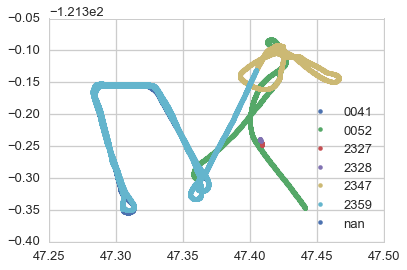

In [6]:
# --------------------------------------------------------------------------------------------
# Clean up the data to use
# Several of the files result in repeated time indices or don't exist or don't include location data
# This creates lots of problems when working in xarray. To alleviate this I'm going to remove the
# troublesome data from analysis on the basis of the below:

# Based on the above let's drop files 1-6 and 9
# Additionally, the '2327' and '2328' flights don't appear to contain actual data. Drop those as well.
irFiles  = [fl10, fl11, fl12, fl13]

# Plot flight lines and flight numbers to diagnose what data to keep
for fln in np.unique(cameraLocDataset.flightNum.values):
    ds = cameraLocDataset.swap_dims({'time': 'flightNum'}).sel(flightNum=fln)
    plt.plot(ds.lat, ds.lon, '.', label=fln)
    plt.legend(loc='best')
    plt.savefig('SNQ.IRFlightNums.png')

## Load ground observations

In [7]:
# --------------------------------------------------------------------------------------------
# Snoqualmie Observations
os.chdir(dirDataSNQ)
SNQ = xr.open_dataset('SnoqualmieObs.SupportData.wy2013_wy2015.nc')
# Need to just select the data on the date of the flights
SNQ_day = SNQ.sel(time=slice('2013-05-14', '2013-05-14 23:00'))
SNQ_day['lat'] = 47.424883
SNQ_day['lon'] = -121.413893

# --------------------------------------------------------------------------------------------
# SNOTEL Observations
os.chdir(dirDataSNOTEL)
SNOTEL = xr.open_dataset('WA_SNOTEL.WY2013.nc')
SNOTEL_day = SNOTEL.sel(time=slice('2013-05-14', '2013-05-14 23:00'))

print(SNQ_day)
print(SNOTEL_day)

<xarray.Dataset>
Dimensions:       (time: 47)
Coordinates:
  * time          (time) datetime64[ns] 2013-05-14 2013-05-14T00:30:00 ...
Data variables:
    JulianDay     (time) int64 134 134 134 134 134 134 134 134 134 134 134 ...
    T4            (time) float64 1.864 1.814 1.797 1.781 1.744 1.625 1.147 ...
    RH4           (time) float64 95.6 96.5 96.7 96.8 96.9 96.9 97.2 97.1 ...
    Precip        (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SurfPres      (time) float64 1.022e+03 1.022e+03 1.022e+03 1.022e+03 ...
    WIND          (time) float64 0.43 0.1285 0.2045 0.029 0.0035 0.0005 ...
    Snowdepth_24  (time) float64 0.007468 0.007468 0.007468 0.007468 ...
    Snowdepth     (time) float64 0.5141 0.5141 0.5159 0.5159 0.5159 0.5141 ...
    Lysimeter     (time) float64 0.0001778 0.000127 0.0001016 5.08e-05 ...
    SW_down_avg   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SW_up_avg     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

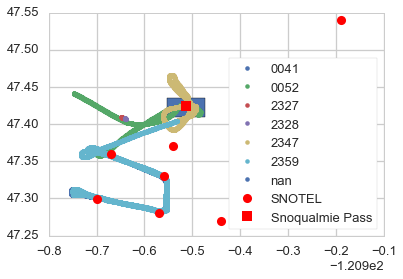

In [8]:
# Plot flight lines and flight numbers to diagnose what data to keep
fig, ax = plt.subplots(1,1)

for fln in np.unique(cameraLocDataset.flightNum.values):
    ds = cameraLocDataset.swap_dims({'time': 'flightNum'}).sel(flightNum=fln)
    ax.plot(ds.lon, ds.lat, '.', label=fln)
    
ax.plot(-SNOTEL.lon, SNOTEL.lat, 'ro', label='SNOTEL')
ax.plot(SNQ_day.lon, SNQ_day.lat, 'rs', label='Snoqualmie Pass')
ax.add_patch(matplotlib.patches.Rectangle((SNQ_day.lon - .04, SNQ_day.lat - .015), .08, 0.025))
plt.legend(loc='best', frameon=True)

# Snoqualmie Observations on this day

In [8]:
SNQ_day

<xarray.Dataset>
Dimensions:       (time: 47)
Coordinates:
  * time          (time) datetime64[ns] 2013-05-14 2013-05-14T00:30:00 ...
Data variables:
    JulianDay     (time) int64 134 134 134 134 134 134 134 134 134 134 134 ...
    T4            (time) float64 1.864 1.814 1.797 1.781 1.744 1.625 1.147 ...
    RH4           (time) float64 95.6 96.5 96.7 96.8 96.9 96.9 97.2 97.1 ...
    Precip        (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SurfPres      (time) float64 1.022e+03 1.022e+03 1.022e+03 1.022e+03 ...
    WIND          (time) float64 0.43 0.1285 0.2045 0.029 0.0035 0.0005 ...
    Snowdepth_24  (time) float64 0.007468 0.007468 0.007468 0.007468 ...
    Snowdepth     (time) float64 0.5141 0.5141 0.5159 0.5159 0.5159 0.5141 ...
    Lysimeter     (time) float64 0.0001778 0.000127 0.0001016 5.08e-05 ...
    SW_down_avg   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SW_up_avg     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 